#Library and functions

In [ ]:
#--- Reproductibility ---
%env PYTHONHASHSEED=0
from numpy.random import seed
seed(42)
from tensorflow import keras
keras.utils.set_random_seed(42)
import tensorflow as tf
tf.config.experimental.enable_op_determinism()
import glob, os

#---

import numpy as np
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from collections import Counter
import PIL
import glob
from tqdm import tqdm
import networkx as nx

#Graphics
from scipy.stats import gaussian_kde
from scipy.stats import norm
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#NN
from tensorflow import keras
from tensorflow.keras import layers, callbacks
#import tensorflow as tf

#sklearn modules: evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, root_mean_squared_error

#Recurrence plots
from pyts.image import RecurrencePlot
from pyts.datasets import load_gunpoint
from mpl_toolkits.axes_grid1 import ImageGrid

#Dynamic time warping: grouping
from dtaidistance import dtw
from dtaidistance import dtw_ndim

env: PYTHONHASHSEED=0


2025-02-20 10:12:58.762050: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 10:12:59.370587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
def parameter_stratification(value):
  '''
  Assumes the parameters of the logistic map will be in the 3 to 4 range.
  Categories:
  1 - Oscillations between two values
  2 - Oscillations between four values
  3 - Oscillations between nth values, where n is even and >4
  4 - Onset of chaos
  5 - Appearance of stability islands
  '''

  #Periods
  if (value < 3.44949):
    return 1
  if ( (value >= 3.44949) and (value < 3.54409) ):
    return 2
  if ( (value >= 3.54409) and (value < 3.56995) ):
    return 3
  if ( (value >= 3.56995) and (value < 3.82843) ):
    return 4
  if ( (value >= 3.82843) ):
    return 5

# Neural net training: regression

##Architecture

In [ ]:
model = keras.Sequential([
  keras.layers.Conv1D(3, 4, activation='relu'),
  keras.layers.Conv1D(3, 4, activation='relu'),
  keras.layers.AveragePooling1D(2),
  keras.layers.Conv1D(3, 4, activation='relu'),
  keras.layers.Conv1D(3, 4, activation='relu'),
  keras.layers.AveragePooling1D(2),
  keras.layers.Conv1D(3, 4, activation='relu'),
  keras.layers.Conv1D(3, 4, activation='relu'),
  keras.layers.AveragePooling1D(2),
  keras.layers.Conv1D(3, 4, activation='relu'),
  keras.layers.Conv1D(3, 4, activation='relu'),
  keras.layers.Flatten(),
  keras.layers.Dense(units=1024, activation='relu'),
  keras.layers.Dense(units=512, activation='relu'),
  keras.layers.Dense(units=256, activation='relu'),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dense(units=1)
])

model.compile(loss='mean_squared_error', optimizer="adam")

## Training

In [ ]:
#Read all pngs from the train set
data_path = '/your/path/'

all_files = glob.glob(os.path.join(data_path , "delta_*.csv"))

li = []
frame_columns = []
for filename in all_files:
  df = pd.read_csv(filename, index_col=None)
  df.rename(columns={'0.1':' 0.1'}, inplace=True)   #[Chaotic region]: df.rename(columns={'3.56':' 3.56'}, inplace=True)
  frame_columns.append(df.columns)                  #[Full region]: df.rename(columns={'3.0':' 3.0'}, inplace=True)
  li.append(df)

frame = pd.concat(li, axis=1, ignore_index=True)

questions = np.array([frame[n] for n in list(frame.columns)]).astype(np.float32)

solutions = []
for n in range(len(frame_columns)):
  for m in range(len(frame_columns[n])):
    solutions.append( frame_columns[n][m].split(" ")[1] )

solutions = np.array(solutions).astype(np.float32)

In [ ]:
N_size = 99

X_train, X_test, y_train, y_test = train_test_split(questions, solutions, test_size=0.3, random_state=42)

X_train = X_train.reshape(-1, N_size, 1)
X_test = X_test.reshape(-1, N_size, 1)

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Epoch 1/300


I0000 00:00:1740055289.868701   13970 service.cc:145] XLA service 0x7fc8c0016f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740055289.868750   13970 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2025-02-20 09:41:29.941565: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-20 09:41:30.244205: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 45/281 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6292

I0000 00:00:1740055291.861842   13970 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1889 - val_loss: 0.0140
Epoch 2/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110 - val_loss: 0.0088
Epoch 3/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 4/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 5/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 6/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 7/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 8/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 9/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 10/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 11/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 12/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

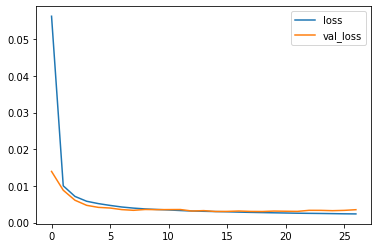

In [ ]:
#Complete region
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=1,  # turn off training log
    shuffle=False
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Epoch 1/300


I0000 00:00:1740057096.034285   23190 service.cc:145] XLA service 0x7f2cb4004670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740057096.034319   23190 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2025-02-20 10:11:36.113856: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-20 10:11:36.388311: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 47/281 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6286

I0000 00:00:1740057098.004779   23190 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2008 - val_loss: 0.0155
Epoch 2/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0148 - val_loss: 0.0140
Epoch 3/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0136 - val_loss: 0.0130
Epoch 4/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0115
Epoch 5/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 6/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0111
Epoch 7/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 8/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088 - val_loss: 0.0096
Epoch 9/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0087
Epoch 10/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - val_loss: 0.0084
Epoch 11/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0066 - val_loss: 0.0084
Epoch 12/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

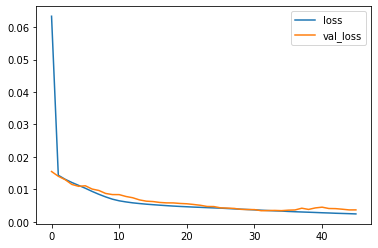

In [ ]:
#[Noise, 5E-3] Full region
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=1,  # turn off training log
    shuffle=False
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Epoch 1/300


I0000 00:00:1740056950.900948   20577 service.cc:145] XLA service 0x7f07280280a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740056950.900983   20577 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2025-02-20 10:09:10.995899: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-20 10:09:11.264763: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 44/281 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6522

I0000 00:00:1740056952.829896   20577 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1990 - val_loss: 0.0163
Epoch 2/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143 - val_loss: 0.0130
Epoch 3/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134 - val_loss: 0.0120
Epoch 4/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127 - val_loss: 0.0117
Epoch 5/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 6/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 7/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 8/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 9/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 10/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - val_loss: 0.0096
Epoch 11/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 12/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

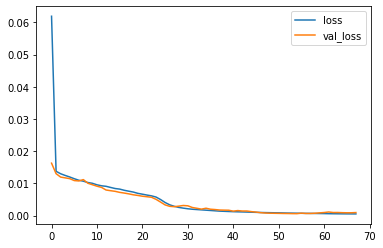

In [ ]:
#[Noise, 1E-3] Full region
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=1,  # turn off training log
    shuffle=False
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Epoch 1/300


I0000 00:00:1740057394.070056   24972 service.cc:145] XLA service 0x7fe9e4017b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740057394.070096   24972 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2025-02-20 10:16:34.148234: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-20 10:16:34.415222: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 47/281 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6968

I0000 00:00:1740057396.007275   24972 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3359 - val_loss: 0.1147
Epoch 2/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0944 - val_loss: 0.0642
Epoch 3/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0535 - val_loss: 0.0413
Epoch 4/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0418 - val_loss: 0.0419
Epoch 5/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0359 - val_loss: 0.0383
Epoch 6/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0307 - val_loss: 0.0289
Epoch 7/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0257 - val_loss: 0.0252
Epoch 8/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0239 - val_loss: 0.0240
Epoch 9/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0228 - val_loss: 0.0215
Epoch 10/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0219 - val_loss: 0.0214
Epoch 11/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0212 - val_loss: 0.0194
Epoch 12/300
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

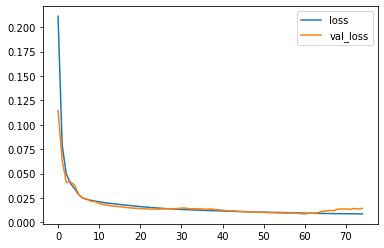

In [ ]:
#[Noise, 1E-1] Full region
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=300,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=1,  # turn off training log
    shuffle=False
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

##Testing

On line 5 of the first cells, there's a renaming of the test set's columns to specific numbers.

These values are generated randomly for each test set, and are left here for reference in case you're reproducing our results.

###Full region, no noise

In [ ]:
#Read all pngs from the train set
data_path = '/your/path/'

ts_test = pd.read_csv(data_path + 'test.csv')
ts_test.rename(columns={'0.10043588':' 0.10043588'}, inplace=True)

test_questions = np.array([ts_test[n] for n in list(ts_test.columns)]).astype(np.float32)
test_solutions = np.array([ts_test.columns[n].split(" ")[1] for n in range(len(ts_test.columns))]).astype(np.float32)

#Apply model:
test_answers = model.predict(test_questions)

In [ ]:
df_res = pd.DataFrame(data={'test_actual': test_solutions, 'test_predictions': test_answers.flatten(), 'N': np.repeat(N_size, len(test_answers))})

In [ ]:
df_res['diff'] = np.abs(df_res['test_actual'] - df_res['test_predictions'])
print(np.min(df_res['diff']))
print(np.max(df_res['diff']))

print('RMSE:', np.round(root_mean_squared_error(df_res['test_actual'].values, df_res['test_predictions'].values), 4))

5.5015087e-05
0.25127518
RMSE: 0.0658


###Full region, 5E-3 noise

In [ ]:
#Read all pngs from the train set
data_path = '/your/path/'

ts_test = pd.read_csv(data_path + 'test.csv')
ts_test.rename(columns={'0.10696412':' 0.10696412'}, inplace=True)

test_questions = np.array([ts_test[n] for n in list(ts_test.columns)]).astype(np.float32)
test_solutions = np.array([ts_test.columns[n].split(" ")[1] for n in range(len(ts_test.columns))]).astype(np.float32)

#Apply model:
test_answers = model.predict(test_questions)

In [ ]:
df_res = pd.DataFrame(data={'test_actual': test_solutions, 'test_predictions': test_answers.flatten(), 'N': np.repeat(N_size, len(test_answers))})

In [ ]:
df_res['diff'] = np.abs(df_res['test_actual'] - df_res['test_predictions'])
print(np.min(df_res['diff']))
print(np.max(df_res['diff']))

print('RMSE:', np.round(root_mean_squared_error(df_res['test_actual'].values, df_res['test_predictions'].values), 4))

3.6597252e-05
0.29437232
RMSE: 0.069


###Full region, 1E-3 noise

In [ ]:
#Read all pngs from the train set
data_path = '/your/path/'
ts_test = pd.read_csv(data_path + 'test.csv')
ts_test.rename(columns={'0.1007786':' 0.1007786'}, inplace=True)

test_questions = np.array([ts_test[n] for n in list(ts_test.columns)]).astype(np.float32)
test_solutions = np.array([ts_test.columns[n].split(" ")[1] for n in range(len(ts_test.columns))]).astype(np.float32)

#Apply model:
test_answers = model.predict(test_questions)

In [ ]:
df_res = pd.DataFrame(data={'test_actual': test_solutions, 'test_predictions': test_answers.flatten(), 'N': np.repeat(N_size, len(test_answers))})

In [ ]:
df_res['diff'] = np.abs(df_res['test_actual'] - df_res['test_predictions'])
print(np.min(df_res['diff']))
print(np.max(df_res['diff']))

print('RMSE:', np.round(root_mean_squared_error(df_res['test_actual'].values, df_res['test_predictions'].values), 4))

1.6868114e-05
0.12245262
RMSE: 0.0264


###Full region, 1E-1 noise

In [ ]:
#Read all pngs from the train set
data_path = '/your/path/'
ts_test = pd.read_csv(data_path + 'test.csv')
ts_test.rename(columns={'0.10026799':' 0.10026799'}, inplace=True)

test_questions = np.array([ts_test[n] for n in list(ts_test.columns)]).astype(np.float32)
test_solutions = np.array([ts_test.columns[n].split(" ")[1] for n in range(len(ts_test.columns))]).astype(np.float32)

#Apply model:
test_answers = model.predict(test_questions)

In [ ]:
df_res = pd.DataFrame(data={'test_actual': test_solutions, 'test_predictions': test_answers.flatten(), 'N': np.repeat(N_size, len(test_answers))})


,test_actual,test_predictions,N
0,0.100268,0.243355,99
1,0.100281,0.284695,99
2,0.100548,0.199584,99
3,0.101517,0.220203,99
4,0.101655,0.280419,99
...,...,...,...
1995,1.992397,1.711944,99
1996,1.992650,1.953021,99
1997,1.995683,1.958798,99
1998,1.997857,1.858188,99


In [ ]:
df_res['diff'] = np.abs(df_res['test_actual'] - df_res['test_predictions'])
print(np.min(df_res['diff']))
print(np.max(df_res['diff']))

print('RMSE:', np.round(root_mean_squared_error(df_res['test_actual'].values, df_res['test_predictions'].values), 4))

5.7965517e-05
0.47784078
RMSE: 0.0982
